# Analysis - User


In [49]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality
from utils.util import get_day_phase, get_hours_from_midnight_of_current_day

import core.config as conf

In [3]:
client

Client Scheduler: tcp://127.0.0.1:41465 Dashboard: http://127.0.0.1:36763/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [4]:
# data_path = conf.raw_data_path + '*' # for all dadtaset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

number of rows: 3033347


In [5]:
total_users = dask_cudf.concat([ori_df["engaged_with_user_id"], ori_df["enaging_user_id"]]).unique().compute()
ori_df, _ = factorize_small_cardinality(ori_df, 'tweet_id')
ori_df, _ = factorize_small_cardinality(ori_df, 'engaged_with_user_id', total_users, True)
ori_df, _ = factorize_small_cardinality(ori_df, 'enaging_user_id', total_users, True)
    

In [6]:
df = ori_df[["tweet_id_encode", "engaged_with_user_id_encode", "enaging_user_id_encode"]]
df['tweet_id_encode'] = df['tweet_id_encode'].astype(np.int32)
df['engaged_with_user_id_encode'] = df['engaged_with_user_id_encode'].astype(np.int32)
df['enaging_user_id_encode'] = df['enaging_user_id_encode'].astype(np.int32)

In [7]:
df.head()

,tweet_id_encode,engaged_with_user_id_encode,enaging_user_id_encode
id,,,
1,2214622,2586120,893844
2,2136815,3355961,3173376
3,1986297,1233947,951213
4,35685,3063535,2013995
5,1465500,2280964,3018294


In [8]:
df

,tweet_id_encode,engaged_with_user_id_encode,enaging_user_id_encode
npartitions=16,,,
1,int32,int32,int32
273141,...,...,...
...,...,...,...
2983130,...,...,...
3033347,...,...,...


## 2. Number of unique users, creators and engagers


In [9]:
unique_creators = df['engaged_with_user_id_encode'].unique().compute().to_array()
unique_engagers = df['enaging_user_id_encode'].unique().compute().to_array()
print(unique_creators)
print(unique_engagers)

[      4      10      14 ... 3511081 3511084 3511089]
[      0       1       2 ... 3511086 3511087 3511088]


In [10]:
unique_users = np.unique(np.append(unique_creators, unique_engagers))
print(unique_users)

[      0       1       2 ... 3511087 3511088 3511089]


## 3. Check the number of users that are both creators and engagers in our train set


In [11]:
unique_creator_engager = np.array(list(set(unique_creators) & set(unique_engagers)))
print(unique_creator_engager)

[2621442 1572869 2621449 ... 1572853  524279 2097148]


In [12]:
print(f"Unique creators are: {len(unique_creators):n}")
print(f"Unique engagers are: {len(unique_engagers):n}")
print(f"Unique users are: {len(unique_users):n}")
print(f"Unique users that are both engager and creator: {len(unique_creator_engager):n}")

Unique creators are: 1558866
Unique engagers are: 2175376
Unique users are: 3511090
Unique users that are both engager and creator: 223152


## 4. Count the number of engagements per engager


In [24]:
cols = [
    'reply_timestamp', 
    'retweet_timestamp',
    'retweet_with_comment_timestamp', 
    'like_timestamp'
]
df[cols] = ori_df[cols]

In [25]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df[['is_like', 'is_retweet', 'is_reply', 'is_comment']].sum(axis=1).astype(np.uint8)
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)


In [29]:
aggregate_result = df.groupby('enaging_user_id_encode').sum().compute()

In [31]:
aggregate_result.head()

,tweet_id_encode,engaged_with_user_id_encode,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
enaging_user_id_encode,,,,,,,,
698016,198979,1153486,0,0,0,0,0,1
1989231,1353721,2574002,0,0,0,0,0,1
45523,511863,2491617,0,0,0,0,0,1
851357,638951,2296516,0,0,0,1,1,0
3038852,6478313,6880702,0,0,0,2,2,1


## 5. How many likes, reply, comment and retweet does an engager have?


LIKE
enaging_user_id_encode
698016      0
1989231     0
45523       0
2415766     0
850314      0
           ..
2363040    51
3494596    54
1278222    54
2558481    59
2989263    73
Name: is_like, Length: 2175376, dtype: int64


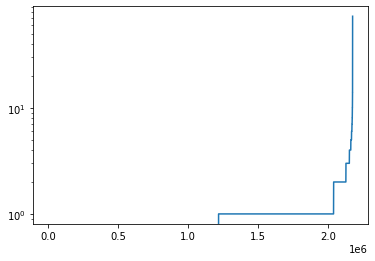

In [34]:
result = aggregate_result["is_like"].sort_values()
print("LIKE")
print(result)

# Plotting the result
plt.clf()
plt.yscale('log')
plt.plot(result.to_array())
plt.show()


REPLY
enaging_user_id_encode
698016     0
1989231    0
45523      0
851357     0
3038852    0
          ..
532819     6
450732     6
2507209    7
3448809    8
1230135    9
Name: is_reply, Length: 2175376, dtype: int64


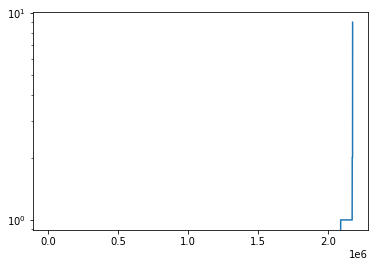

In [35]:
result = aggregate_result["is_reply"].sort_values()
print("REPLY")
print(result)

# Plotting the result
plt.clf()
plt.yscale('log')
plt.plot(result.to_array())
plt.show()

COMMENT
enaging_user_id_encode
698016     0
1989231    0
45523      0
851357     0
3038852    0
          ..
2739841    6
1450427    6
980060     6
3310944    7
716502     9
Name: is_comment, Length: 2175376, dtype: int64


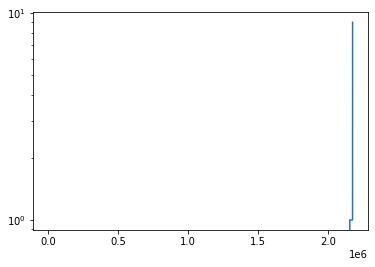

In [36]:
result = aggregate_result["is_comment"].sort_values()
print("COMMENT")
print(result)

# Plotting the result
plt.clf()
plt.yscale('log')
plt.plot(result.to_array())
plt.show()

RETWEET
enaging_user_id_encode
698016      0
1989231     0
45523       0
851357      0
3038852     0
           ..
3116796    24
1923965    25
214255     25
3469455    26
1155250    32
Name: is_retweet, Length: 2175376, dtype: int64


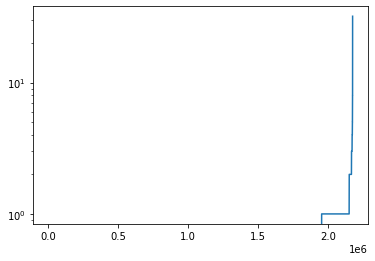

In [37]:
result = aggregate_result["is_retweet"].sort_values()
print("RETWEET")
print(result)

# Plotting the result
plt.clf()
plt.plot(result.to_array())
plt.show()

POSITIVE
enaging_user_id_encode
698016      0
1989231     0
45523       0
2415766     0
850314      0
           ..
3494596    54
3116796    57
2558481    59
1278222    69
2989263    73
Name: is_positive, Length: 2175376, dtype: int64


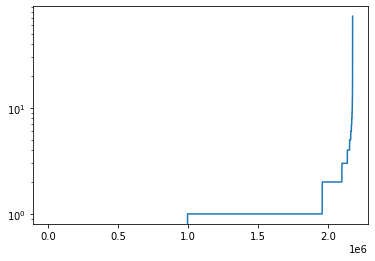

In [38]:
result = aggregate_result["is_positive"].sort_values()
print("POSITIVE")
print(result)

# Plotting the result
plt.clf()
plt.yscale('log')
plt.plot(result.to_array())
plt.show()

NEGATIVE
enaging_user_id_encode
851357      0
1459108     0
3138220     0
2914758     0
3019350     0
           ..
2942553     8
1999229     8
476905      9
2958362     9
620862     10
Name: is_negative, Length: 2175376, dtype: int64


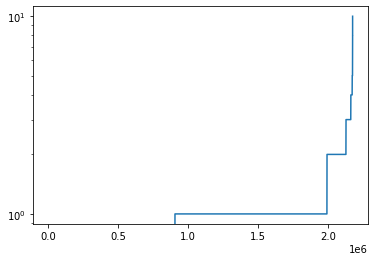

In [39]:
result = aggregate_result["is_negative"].sort_values()
print("NEGATIVE")
print(result)

# Plotting the result
plt.clf()
plt.yscale('log')
plt.plot(result.to_array())
plt.show()

## 6. Let's see the behaviour of the user that usually put likes

<AxesSubplot:xlabel='enaging_user_id_encode'>

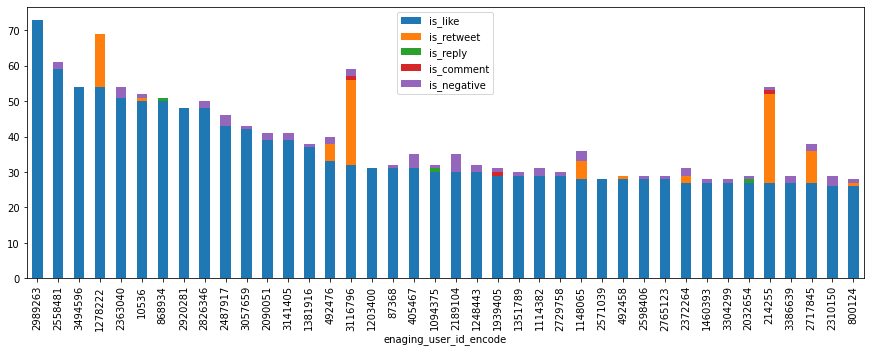

In [66]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_like", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


## 7. Let's the behaviour of the user that usually put reply


<AxesSubplot:xlabel='enaging_user_id_encode'>

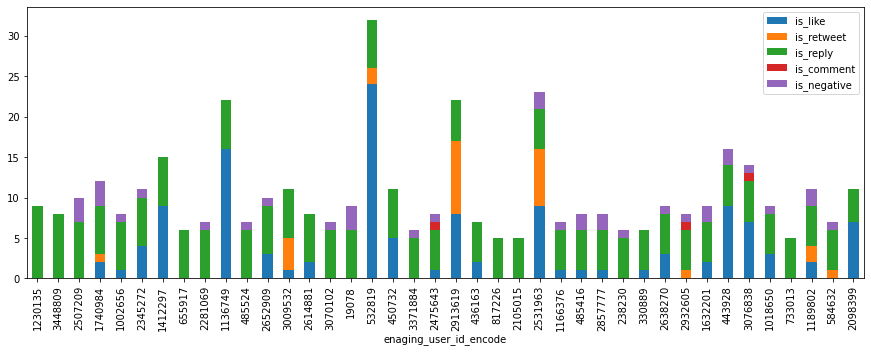

In [65]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_reply", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


## 8. Let's the behaviour of the user that usually put retweet¶


<AxesSubplot:xlabel='enaging_user_id_encode'>

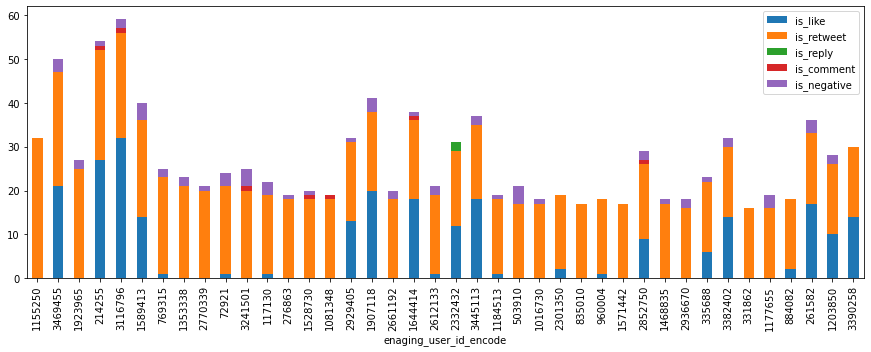

In [67]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_retweet", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


## 9. Let's the behaviour of the user that usually put retweet with comment


<AxesSubplot:xlabel='enaging_user_id_encode'>

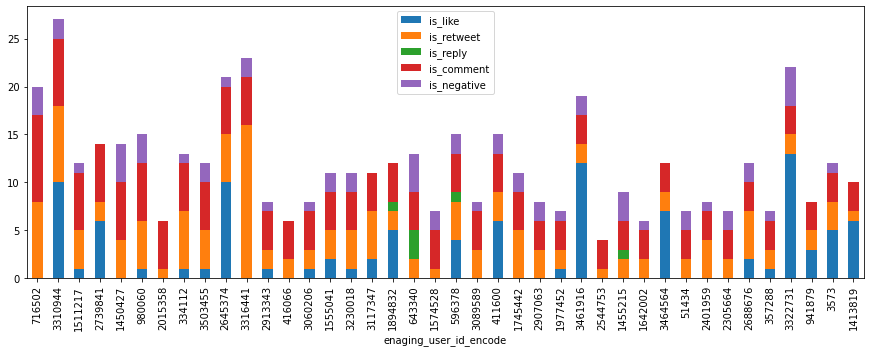

In [68]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_comment", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


## 10. Let's the behaviour of the user that usually has positive engagement


<AxesSubplot:xlabel='enaging_user_id_encode'>

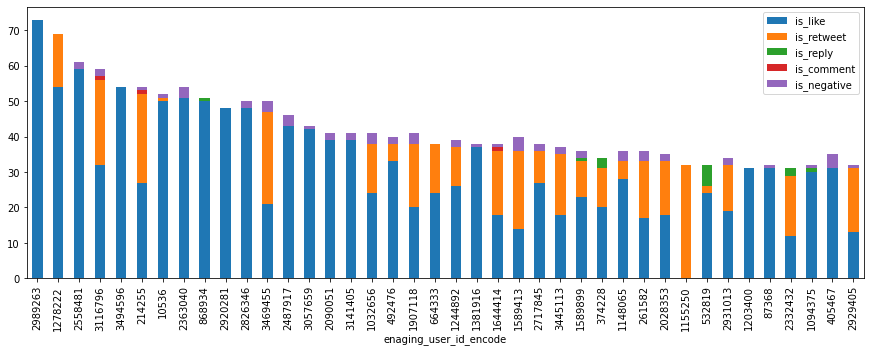

In [69]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result.sort_values("is_positive", ascending=False)[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]][:40].to_pandas().plot.bar(stacked=True)


## 11. Let's the behaviour of the user that usually has negative engagement


<AxesSubplot:xlabel='enaging_user_id_encode'>

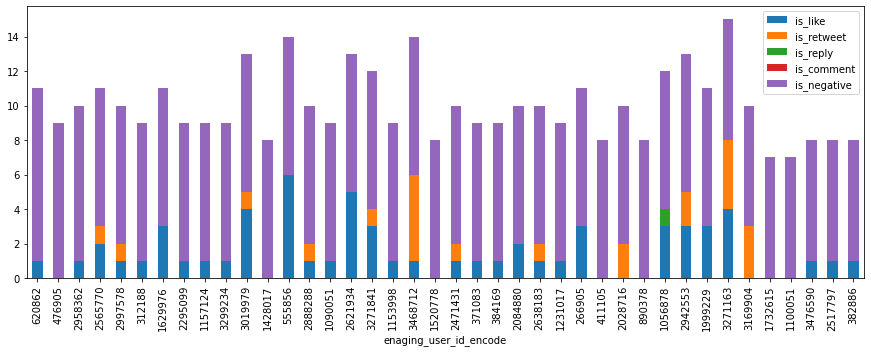

In [70]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_negative", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


## 12. Let's change topic and see how many tweets a user has created (user that are no creators are ignored)


In [76]:
df.head()

,tweet_id_encode,engaged_with_user_id_encode,enaging_user_id_encode,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
id,,,,,,,,,
1,2214622,2586120,893844,0,0,0,1,1,0
2,2136815,3355961,3173376,0,0,0,0,0,1
3,1986297,1233947,951213,1,0,0,0,1,0
4,35685,3063535,2013995,0,0,0,1,1,0
5,1465500,2280964,3018294,0,0,0,0,0,1


In [94]:
sorted_result = df.drop_duplicates(["engaged_with_user_id_encode", "tweet_id_encode"]).groupby("engaged_with_user_id_encode").size().compute()
sorted_result = sorted(sorted_result.to_array())[-20:]
print(sorted_result)

[332, 346, 351, 354, 356, 359, 361, 379, 387, 419, 419, 448, 460, 468, 480, 491, 567, 654, 920, 1376]


### On Y we have the count of tweets created, on X we have users sorted by the count


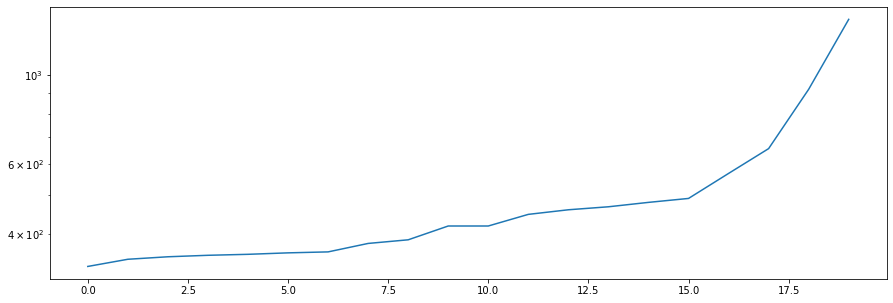

In [95]:
plt.yscale('log')
plt.plot(range(len(sorted_result)), sorted_result)
plt.show()

## 13. Let's see which is the creator that have RECEIVED the most engagements


In [99]:
aggregate_result = df.drop_duplicates(["engaged_with_user_id_encode", "tweet_id_encode"]).drop(columns=["tweet_id_encode", "enaging_user_id_encode"]).groupby("engaged_with_user_id_encode").sum().compute()

In [101]:
aggregate_result.head()

,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
engaged_with_user_id_encode,,,,,,
3354909,0,0,0,0,0,1
2561411,0,0,0,0,0,1
1330293,0,0,0,0,0,1
2229111,0,0,0,0,0,1
2379916,0,0,0,1,1,0


### Users that received more likes

<AxesSubplot:xlabel='engaged_with_user_id_encode'>

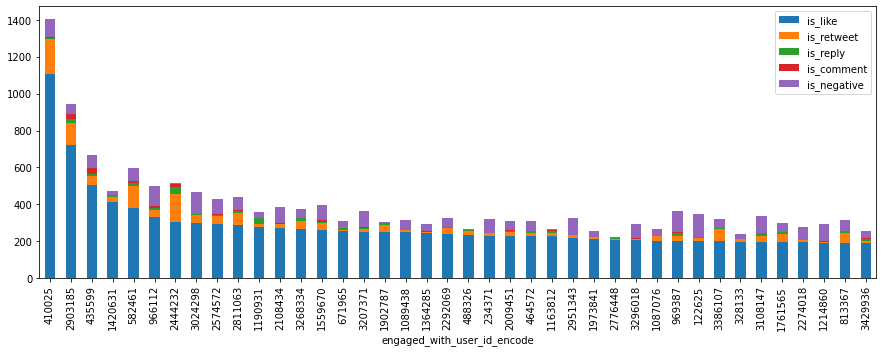

In [102]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_like", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


### Users that received more replies


<AxesSubplot:xlabel='engaged_with_user_id_encode'>

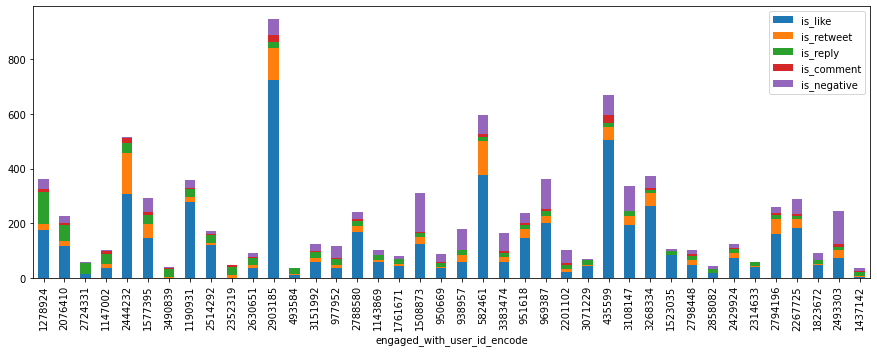

In [103]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_reply", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


### Users that received more retweets

<AxesSubplot:xlabel='engaged_with_user_id_encode'>

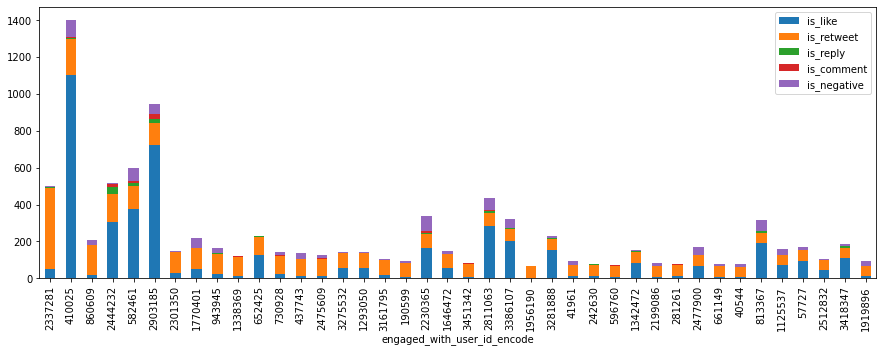

In [104]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_retweet", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


### Users that received more comments


<AxesSubplot:xlabel='engaged_with_user_id_encode'>

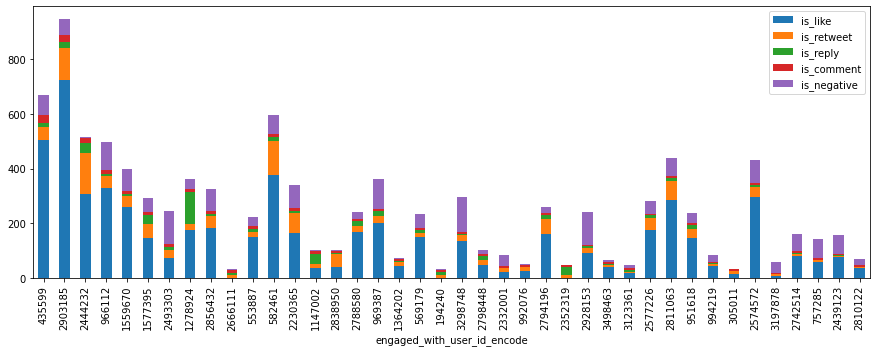

In [105]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_comment", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


### Users that received more negative engagements


<AxesSubplot:xlabel='engaged_with_user_id_encode'>

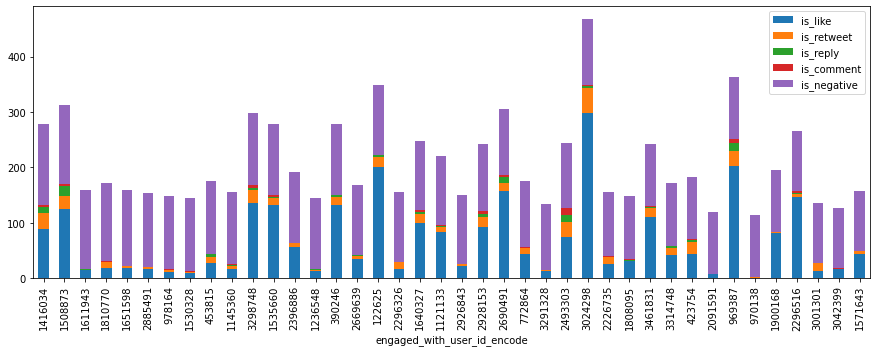

In [106]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]].sort_values("is_negative", ascending=False)[:40].to_pandas().plot.bar(stacked=True)


### Users that received more positive engagements


<AxesSubplot:xlabel='engaged_with_user_id_encode'>

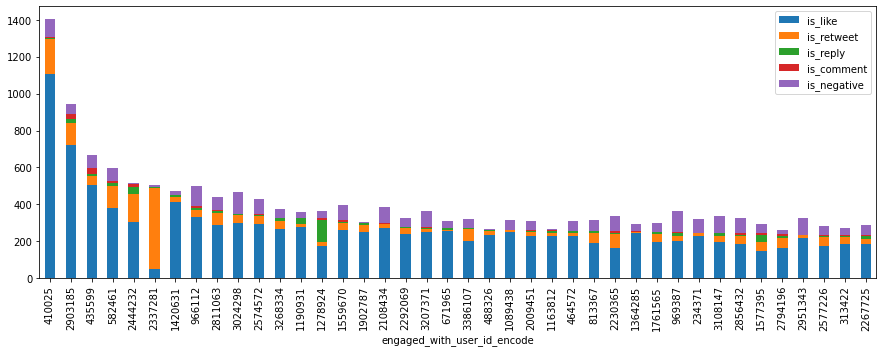

In [107]:
plt.rcParams['figure.figsize'] = [15, 5]
aggregate_result.sort_values("is_positive", ascending=False)[[
    "is_like",
    "is_retweet",
    "is_reply",
    "is_comment",
    "is_negative"
]][:40].to_pandas().plot.bar(stacked=True)


In [108]:
aggregate_result.sort_values("is_positive", ascending=False)[:40]

,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
engaged_with_user_id_encode,,,,,,
410025,6,192,3,1104,1305,97
2903185,24,116,25,724,889,56
435599,15,49,28,503,595,75
582461,16,123,9,378,526,70
2444232,37,150,17,307,511,3
2337281,4,440,2,49,495,8
1420631,12,26,1,413,452,23
966112,7,42,15,330,394,104
2811063,11,69,6,286,372,66
